In [1]:
from multiprocessing import Pool, cpu_count
import os
from pathlib import Path
import yaml

import numpy as np
import numexpr
import pandas as pd
import scipy.stats as stats
from sklearn.preprocessing import StandardScaler

import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from scripts.general import data, preprocess, plotting


tqdm.pandas(desc='Pandas op')
MAX_PROC = cpu_count() - 2
numexpr.set_num_threads(MAX_PROC)


plt.rcParams['font.size'] = 14

%load_ext autoreload
%autoreload 2

## Get tAI values

In [2]:
tai = pd.read_csv('../../data/seq/codons/tai_yeast_ecoli.csv')
tai = tai[['Codon', 'S. cerevisiae']].rename(columns = {'S. cerevisiae': 'w'})
tai['w'] = tai['w'].astype('float32')

codon_rel_adaptiveness = {
    codon: w for codon, w in tai.values
}

In [3]:
genes = preprocess.fasta_to_seq_df(
    '../../data/seq/S288C_reference_genome_R64-2-1_20150113/orf_coding_all_R64-2-1_20150113.fasta',
    id_name='Systematic_Name',
    id_extract_func = lambda record: record.id.split(' ')[0]
).rename(
    columns={'seq': 'dna_seq'}
)

In [4]:
genes.shape

(6713, 2)

Filter out sequences that are not multiples of 3

In [5]:
genes = genes[genes['dna_seq'].map(lambda s: len(s) % 3 == 0)]

genes.shape

(6711, 2)

In [6]:
def gene_tai(seq: str, weights_lookup: dict) -> np.ndarray:
    """
    Get the gene tAI using the relative codong adaptiveness `weights_lookup`
    Assumes sequence is a multiple of 3.
    """
    n_codons = len(seq) // 3
    
    w = np.zeros(n_codons, dtype='float32')
    for i in range(n_codons):
        w[i] = weights_lookup[seq[i * 3 : (i + 1) * 3]]
    
    return stats.gmean(w)
    

# TEST
assert np.isclose(
    gene_tai('TTTTTCTTA', codon_rel_adaptiveness),
    stats.gmean([0.27032, 0.615764, 0.431034])
)

Calculate gene tAI values. Make sure to exclude the stop codon.

In [7]:
genes = genes.assign(
    tAI = genes['dna_seq'].map(lambda s: gene_tai(s[:-3], codon_rel_adaptiveness))
)

Filter out NaNs, arising from in-frame stop codons, like YDR134C  https://www.yeastgenome.org/locus/S000002541

In [8]:
genes = genes[~genes['tAI'].isna()]

genes.shape

(6685, 3)

In [9]:
genes = genes.assign(
    tAI_zscore = StandardScaler().fit_transform(genes[['tAI']])
)

## Get mF values

In [10]:
folding = pd.read_csv('../../data/mrna_folding/sce_Score.tab.gz', sep='\t', 
                      header=0, names = ['gene_id', 'gene_length', 'PARS'])

In [11]:
folding = folding.assign(
    mF = folding['PARS'].map(
        lambda scores: np.mean(list(map(float, scores.split(';'))))
    )
).drop(columns=['PARS'])

folding = folding.assign(
     mF_zscore = StandardScaler().fit_transform(folding[['mF']])
)

## Get BERT predictions

In [12]:
all_median_abundances = pd.read_csv('../../data/ho2018/prot_abundance_molecules_per_cell_no_gfp.csv')
id_matching = all_median_abundances[['Systematic_Name', 'swissprot_ac']]

pred = pd.read_csv('../20211223_182228/model_test_predictions.csv.gz').merge(id_matching, on='swissprot_ac')

In [13]:
pred = pred.assign(
    pred_residuals = pred['Median_molecules_per_cell'] - pred['predictions_test']
)

In [14]:
pred_and_vars = pd.merge(
    pred.drop(columns=['seq', 'swissprot_ac']),
    genes.drop(columns=['dna_seq'])
)

In [15]:
pred_and_vars.shape

(436, 6)

In [16]:
pred_and_vars.head(4)

,Median_molecules_per_cell,predictions_test,Systematic_Name,pred_residuals,tAI,tAI_zscore
0,6.056560,5.771559,YHR177W,0.285001,0.312017,-0.722107
1,7.003393,7.505554,YAL049C,-0.502161,0.398815,0.559470
2,5.708121,5.974726,YPR085C,-0.266605,0.321840,-0.577077
3,6.187091,5.946874,YJL110C,0.240217,0.298813,-0.917068


### mF will be a subset

Since measurements were made for about 3000 genes

In [17]:
pred_and_vars_mf_subset = pd.merge(
    pred_and_vars,
    folding,
    left_on='Systematic_Name', right_on='gene_id'
)

pred_and_vars_mf_subset.shape

(239, 10)

In [18]:
pred_mf_subset = pd.merge(
    pred,
    folding,
    left_on='Systematic_Name', right_on='gene_id'
)

pred_mf_subset.shape

(239, 10)

In [19]:
pred_and_vars_mf_subset.head(4)

,Median_molecules_per_cell,predictions_test,Systematic_Name,pred_residuals,tAI,tAI_zscore,gene_id,gene_length,mF,mF_zscore
0,7.003393,7.505554,YAL049C,-0.502161,0.398815,0.559470,YAL049C,890,0.287744,0.094398
1,6.980684,6.802645,YMR058W,0.178039,0.388923,0.413418,YMR058W,2101,0.964539,2.662250
2,5.905004,5.517097,YNL289W,0.387907,0.333018,-0.412031,YNL289W,1069,0.290318,0.104165
3,6.243851,6.893354,YLR130C,-0.649504,0.335456,-0.376026,YLR130C,1457,0.346805,0.318484


## Correlations

In [20]:
def signif_corr(a: np.ndarray, b: np.ndarray) -> float:
    corr, pvalue = stats.pearsonr(a, b)
    if pvalue < 0.05:
        return corr
    else:
        return np.nan
    
pred_and_vars.drop(columns=['Median_molecules_per_cell', 'Systematic_Name', 'tAI']).corr(method=signif_corr)

,predictions_test,pred_residuals,tAI_zscore
predictions_test,1.000000,NaN,0.729222
pred_residuals,NaN,1.00000,0.337770
tAI_zscore,0.729222,0.33777,1.000000


In [21]:
stats.pearsonr(
    pred_and_vars['predictions_test'], 
    pred_and_vars['pred_residuals']
)

(-0.018637820711459883, 0.6979526719267706)

### 1. tAI

In [22]:
stats.pearsonr(
    pred_and_vars['predictions_test'],
    pred_and_vars['tAI_zscore']
)

(0.7292219843275917, 1.6215599310925052e-73)

In [23]:
stats.pearsonr(
    pred_and_vars['pred_residuals'],
    pred_and_vars['tAI_zscore']
)

(0.337769684336558, 4.271929714951881e-13)

### 2. mF

In [24]:
stats.pearsonr(
    pred_mf_subset['predictions_test'],
    pred_mf_subset['mF_zscore']
)

(0.45159457869819175, 2.0642433074496902e-13)

In [25]:
stats.pearsonr(
    pred_and_vars_mf_subset['pred_residuals'],
    pred_and_vars_mf_subset['mF_zscore']
)

(0.36488596959236747, 6.133033624323248e-09)

In [26]:
stats.pearsonr(
    pred_mf_subset['Median_molecules_per_cell'],
    pred_mf_subset['mF_zscore']
)

(0.5711021014006098, 4.343890033681415e-22)

In [27]:
factors = pd.merge(
    genes.drop(columns=['dna_seq']),
    folding.drop(columns=['gene_length']),
    left_on='Systematic_Name', right_on='gene_id'
)

factors.shape

(2999, 6)

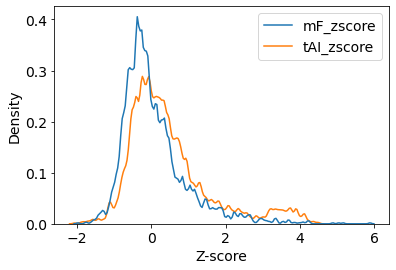

In [28]:
sns.kdeplot(
    factors[['mF_zscore', 'tAI_zscore']],
    bw_adjust=0.2
).set(
    xlabel='Z-score'
);

## Partial Correlations

In [29]:
import networkx as nx


def draw_factor_graph(graph: nx.Graph, layout = 'circular', font_size=14, widths=1.5, node_size=1000):
    """
    :param layout: 'spring', 'circular', 'planar' or NetworkX position dictionary
    """
    draw_options = {
        "font_size": font_size,
        "node_size": node_size,
        "node_shape": "s",
        "node_color": "white",
        "edgecolors": "black",
        "linewidths": widths,
        "width": widths
    }

    if isinstance(layout, str):
        layout = {
            'spring': nx.spring_layout(graph, seed=123),
            'circular': nx.circular_layout(graph),
            'planar': nx.planar_layout(graph, scale=2),
        }[layout]
    else:
        layout = layout
        
    nx.draw(
        graph,
        labels = {n: n for n in graph},
        pos = layout,
        **draw_options
    );

    nx.draw_networkx_edge_labels(
        graph, 
        edge_labels = {edge: f"{graph[edge[0]][edge[1]]['weight'] :.2f}" for edge in graph.edges},
        font_size = font_size,
        rotate = False,
        pos = layout
    );

    axis_scaling = 1.1
    axis = plt.gca()
    axis.set_xlim([axis_scaling * x for x in axis.get_xlim()])
    axis.set_ylim([axis_scaling * y for y in axis.get_ylim()])
    
    
def get_pairwise_measure_graph(table: pd.DataFrame, diag = 1) -> nx.Graph:
    """
    Use upper triangular matrix of the given pairwise measures table.
    Assumes the values are symmetrical.
    
    :param diag: Which diagonal to use when taking the upper triangular matrix. 
                 E.g. `diag = 0` includes matrix diagonal (self-values / self-loops),
                 not included by default.
    """
    graph = nx.from_numpy_array(np.triu(table.values, k = diag))
    graph = nx.relabel_nodes(
        graph, 
        {i: label for i, label in enumerate(map(lambda name: name.split('_')[0], table.columns))}
    )
    return graph

In [30]:
import pingouin as pg
from collections import defaultdict


def partial_corr_table(factors: pd.DataFrame) -> pd.DataFrame:
    """
    Obtain the significant (p-value < 0.05) partial Pearson correlations 
    for all pairs of (distinct) factor columns in the DataFrame.
    
    Partial correlations with higher p-values or between the same columns are recorded as NaN.
    """
    
    col_names = list(factors.columns)
    col_idx = {name: idx for idx, name in enumerate(col_names)}
    
    par_corrs = defaultdict(defaultdict)
    
    for x in col_names:
        for y in col_names:
            if x != y:
                controlling_vars = sorted(set(factors.columns) - {x, y})
                pcorr = pg.partial_corr(data=factors, x=x, y=y, covar=controlling_vars).to_dict()
        
                if pcorr['p-val']['pearson'] < 0.05:
                    par_corrs[x][y] = pcorr['r']['pearson']

    par_corrs = pd.DataFrame.from_dict(par_corrs)

    # Make sure rows in same order as columns
    par_corrs = par_corrs.assign(
        col_idx = par_corrs.index.map(lambda name: col_idx[name])
    )
    par_corrs = par_corrs.sort_values('col_idx').drop(columns=['col_idx'])
    
    return par_corrs

In [31]:
partial_corr_table(factors[['tAI_zscore','mF_zscore']])

,tAI_zscore,mF_zscore
tAI_zscore,NaN,0.511077
mF_zscore,0.511077,NaN


### Look at subset including predictions

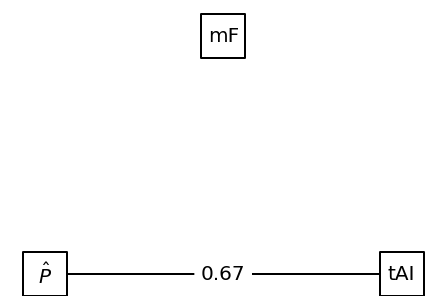

In [32]:
par_corr_pred = partial_corr_table(
    pred_and_vars_mf_subset[
        ['predictions_test', 'tAI_zscore','mF_zscore']
    ].rename(
        columns={
            'predictions_test': '$\hat{P}$'
        }
    )
).fillna(0)


par_corr_pred_graph = get_pairwise_measure_graph(par_corr_pred)


par_corr_pred_graph.remove_edges_from([
    ('tAI', 'mF')
])

draw_factor_graph(par_corr_pred_graph, layout='planar', font_size=20, widths=2, node_size=2000)

In [33]:
pg.partial_corr(data=pred_and_vars_mf_subset, x='predictions_test', y='tAI_zscore', covar='mF_zscore')

,n,r,CI95%,p-val
pearson,239,0.670599,"[0.59, 0.74]",1.891458e-32


In [34]:
pg.partial_corr(data=pred_and_vars_mf_subset, x='predictions_test', y='mF_zscore', covar='tAI_zscore')

,n,r,CI95%,p-val
pearson,239,-0.009733,"[-0.14, 0.12]",0.881259


In [35]:
pg.partial_corr(data=pred_and_vars_mf_subset, x='Median_molecules_per_cell', y='mF_zscore', covar='tAI_zscore')

,n,r,CI95%,p-val
pearson,239,0.135518,"[0.01, 0.26]",0.03668


In [36]:
pg.partial_corr(data=pred_and_vars_mf_subset, x='Median_molecules_per_cell', y='tAI_zscore', covar='mF_zscore')

,n,r,CI95%,p-val
pearson,239,0.759421,"[0.7, 0.81]",5.959058e-46


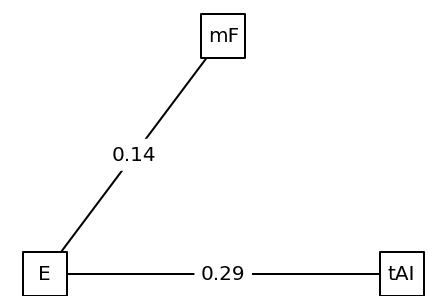

In [37]:
par_corr_resid = partial_corr_table(
    pred_and_vars_mf_subset[
        ['pred_residuals', 'tAI_zscore','mF_zscore']
    ].rename(
        columns={
            'pred_residuals': 'E'
        }
    )
).fillna(0)

par_corr_resid_graph = get_pairwise_measure_graph(par_corr_resid)

par_corr_resid_graph.remove_edges_from([
    ('tAI', 'mF')
])

draw_factor_graph(par_corr_resid_graph, layout='planar', font_size=20, widths=2, node_size=2000)

In [38]:
pg.partial_corr(data=pred_and_vars_mf_subset, x='pred_residuals', y='tAI_zscore', covar='mF_zscore')

,n,r,CI95%,p-val
pearson,239,0.291364,"[0.17, 0.4]",0.000005


In [39]:
pg.partial_corr(data=pred_and_vars_mf_subset, x='pred_residuals', y='tAI_zscore', covar='mF_zscore')

,n,r,CI95%,p-val
pearson,239,0.291364,"[0.17, 0.4]",0.000005


In [40]:
excluded_cols = ['Systematic_Name', 'gene_id', 'gene_length', 
                 'Median_molecules_per_cell', 'tAI', 'mF']

In [41]:
pg.partial_corr(data=pred_and_vars_mf_subset.drop(columns=excluded_cols), 
                x = 'predictions_test', y = 'mF_zscore', 
                covar = list(set(pred_and_vars_mf_subset.drop(columns=excluded_cols).columns) 
                             - {'predictions_test', 'mF_zscore'}))

,n,r,CI95%,p-val
pearson,239,0.067824,"[-0.06, 0.19]",0.298426


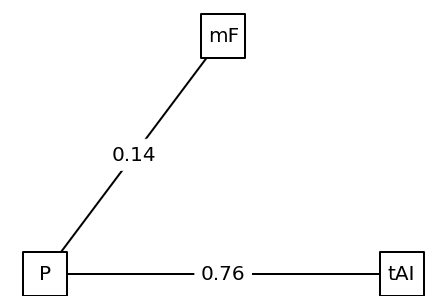

In [42]:
par_corr_abundance = partial_corr_table(
    pred_and_vars_mf_subset[
        ['Median_molecules_per_cell', 'tAI_zscore','mF_zscore']
    ].rename(
        columns={
            'Median_molecules_per_cell': 'P'
        }
    )
).fillna(0)

par_corr_abundance_graph = get_pairwise_measure_graph(par_corr_abundance)


par_corr_abundance_graph.remove_edges_from([
    ('tAI', 'mF')
])

draw_factor_graph(par_corr_abundance_graph, layout='planar', font_size=20, widths=2, node_size=2000)